In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
import time
from pennylane.optimize import AdamOptimizer
import torch

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [11, 7]
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

In [2]:
nbatch = 2000
num_dim = 1
num_discrete_values = 16
num_qubits = 1 * int(np.log2(num_discrete_values))

N = 20000

reg = 0.000001

In [3]:
from scipy.stats import multivariate_normal

grid_elements = np.arange(0, 16)
data = np.random.normal(7,1.5,N).astype(int)

values, counts = np.unique(data, return_counts=True)

x=np.arange(0,16)
zerovals = [i for i in x if i not in values]
zeros = np.zeros(len(zerovals))
values = np.append(values, zerovals)
counts = np.append(counts, zeros)

idx = np.argsort(values)

values = values[idx]
counts = counts[idx]

prob_data = counts/N

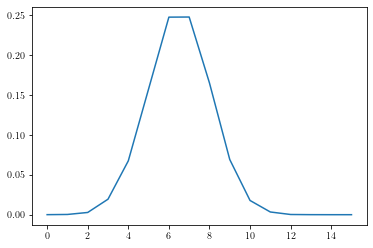

In [4]:
plt.plot(prob_data)
plt.show()

In [5]:
dev = qml.device("default.qubit.torch", wires=num_qubits)

@qml.qnode(dev, interface="torch", diff_method="backprop")
def circuit(inputs, weights):
    for wire in range(num_qubits): qml.Hadamard(wires=wire)
    qml.StronglyEntanglingLayers(weights=weights, wires=list(range(num_qubits)))
    return qml.probs()

In [6]:
dev_sample = qml.device("default.qubit", wires=num_qubits, shots=nbatch)

@qml.qnode(dev_sample, interface="torch")
def circuit_sample(inputs, weights):
    for wire in range(num_qubits): qml.Hadamard(wires=wire)
    qml.StronglyEntanglingLayers(weights=weights, wires=list(range(num_qubits)))
    return qml.sample(wires=[0,1,2,3])

In [7]:
n_layers=8
weight_shapes = {"weights": (n_layers, num_qubits,3)}

In [8]:
qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)

In [9]:
from torch import nn


class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()

        self.linear_input = nn.Linear(input_size, 50)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.linear1 = nn.Linear(50, 20)
        self.linear2 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.linear_input(input)
        x = self.leaky_relu(x)
        x = self.linear1(x)
        x = self.leaky_relu(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        return x

In [10]:
generator = qlayer
discriminator = Discriminator(num_dim)

In [11]:
from torch.optim import Adam

lr = 0.0001  # learning rate
#b1 = 0.7  # first momentum parameter
b1 = 0.6  # first momentum parameter
b2 = 0.999  # second momentum parameter

generator_optimizer = Adam(generator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0, amsgrad=True)
discriminator_optimizer = Adam(
    discriminator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0, amsgrad=True
)

decayRate = 0.9999
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=generator_optimizer, gamma=decayRate)

In [12]:
from IPython.display import clear_output

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

def plot_training_progress(n, samples_tuple):
    # we don't plot if we don't have enough data
    if len(generator_loss_values) < 2:
        return

    clear_output(wait=True)
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 12))
    fig.tight_layout(pad=6.0)

    # Generator Loss
    ax3.plot(generator_loss_values, label="generator loss", color="royalblue")
    ax3.plot(discriminator_loss_values, label="discriminator loss", color="magenta")
    ax3.legend(loc="best", fontsize=16)
    ax3.set_xlabel("epoch", fontsize=16)
    ax3.set_ylabel("Loss", fontsize=16)
    #ax3.grid()

    # Relative Entropy
    ax2.plot(entropy_values)
    ax2.set_xlabel("epoch", fontsize=18)
    ax2.set_ylabel("KL divergence", fontsize=18)
    ax2.set_yscale("log")
    #ax2.grid()
    
    paramsg = generator.weights
    generated_probabilities = circuit(1,paramsg).detach()
    ax1.plot(generated_probabilities, label="generated")
    ax1.plot(prob_data,label="real")
    ax1.legend(loc="upper right", fontsize=18)
    ax1.set_xlabel("$i$", fontsize=18)
    ax1.set_ylabel("$P_i$", fontsize=18)
    #ax3.grid()
    #plt.savefig(f"imgs/plt-{n}.png")
    
    ax4.plot(discriminator(torch.tensor(list(range(16))).reshape(16,1).float()).detach())
    ax4.set_xlabel("$i$", fontsize=18)
    ax4.set_ylabel("$D(i)$", fontsize=18)
    
    for samples in samples_tuple:
        values, counts = np.unique(samples, return_counts=True)
        if (values == np.arange(0,16)).all(): ax5.plot(counts)
    ax5.set_xlabel("i")
    ax5.set_ylabel("sample distribution")
        

    plt.show()

In [13]:
def tensor_to_int(tensor):
    tensor = tensor.long()
    
    # Calculate the number of columns in the tensor
    num_columns = tensor.size(1)
    
    # Create a weight tensor for binary to integer conversion
    weights = 2 ** torch.arange(num_columns - 1, -1, -1)
    
    # Calculate the integer values for each row
    int_values = torch.sum(tensor * weights, dim=1)
    
    return int_values

In [14]:
def adversarial_loss(inputs, target, w):
    #print(input.shape)
    #print(w.shape)
    #print(target.shape)
    bce_loss = target * torch.log(inputs) + (1 - target) * torch.log(1 - inputs)
    #print(bce_loss.shape)
    weighted_loss = w * bce_loss
    #print(weighted_loss.shape)
    total_loss = -torch.sum(weighted_loss)
    return total_loss

In [15]:
def iterate_minibatches(data, batch_size):
    for start_idx in range(0, data.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield data[idxs]

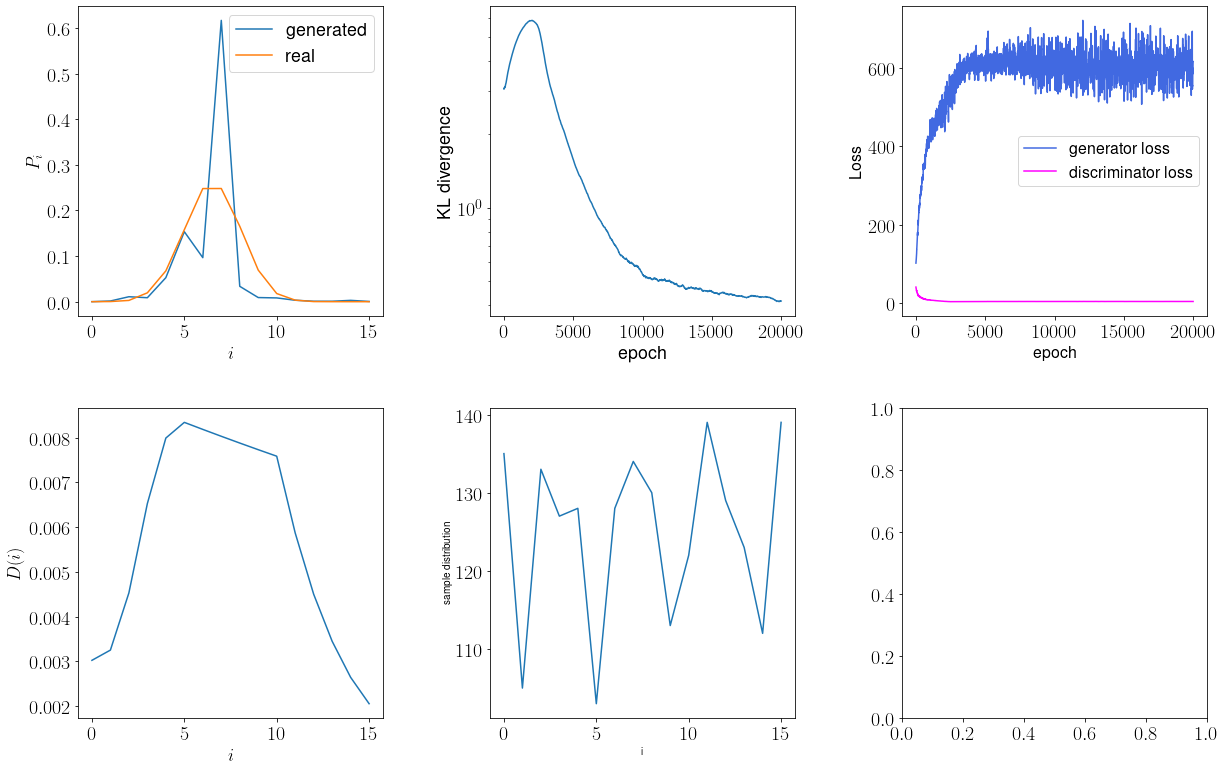

Fit in 49130.86 sec


In [16]:
import time
from scipy.stats import multivariate_normal, entropy

torch.nn.init.uniform_(list(generator.parameters())[0], a=-np.pi, b=np.pi)

n_epochs = 2000

num_qnn_outputs = num_discrete_values**num_dim

data = torch.tensor(data, requires_grad=False)

generator_loss_values = []
discriminator_loss_values = []
entropy_values = []

start = time.time()
for epoch in range(n_epochs):

    valid = torch.ones(nbatch, dtype=torch.float)
    fake = torch.zeros(nbatch, dtype=torch.float)

    #samples = tensor_to_int(circuit_sample(1, list(generator.parameters())[0].detach()))
    samples = torch.tensor(np.random.randint(0,16, size=(nbatch,)), dtype=torch.float).reshape(nbatch,1)
    #samples = samples.float().reshape(-1,1)
    
    for j,Xbatch in enumerate(iterate_minibatches(data, batch_size=nbatch)):
    
        # discriminator values
        disc_value = discriminator(samples)
    
        # gen dist
        gen_dist = generator(torch.tensor([]))

        # Train generator
        generator_optimizer.zero_grad()
        generator_loss = adversarial_loss(disc_value.detach().reshape(-1), valid, gen_dist[samples.long().reshape(-1)])

        # store for plotting
        generator_loss_values.append(generator_loss.detach().item())

        generator_loss.backward(retain_graph=True)
        generator_optimizer.step()

        # Train Discriminator
        discriminator_optimizer.zero_grad()
     
        real_disc_vals = discriminator(Xbatch.float().reshape(-1,1))
    
        real_loss = adversarial_loss(real_disc_vals.reshape(-1), valid, torch.tensor(np.ones(nbatch)*1/nbatch, requires_grad=False))
        fake_loss = adversarial_loss(disc_value.reshape(-1), fake, gen_dist.detach()[samples.long().reshape(-1)])
        discriminator_loss = (real_loss + fake_loss) / 2

        # Store for plotting
        discriminator_loss_values.append(discriminator_loss.detach().item())

        discriminator_loss.backward()
        discriminator_optimizer.step()
        
        entropy_value = entropy(gen_dist.detach().squeeze().numpy()+reg, prob_data+reg)
        entropy_values.append(entropy_value)

        my_lr_scheduler.step()
    
        plot_training_progress(epoch, (samples,))
    
elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} sec")

In [17]:
np.sum(discriminator(torch.tensor(list(range(16))).reshape(16,1).float()).detach().numpy())

0.09158531

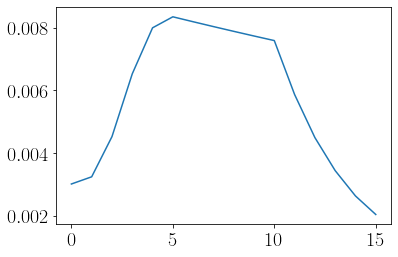

In [18]:
plt.plot(discriminator(torch.tensor(list(range(16))).reshape(16,1).float()).detach())

(array([240., 133., 255., 103., 262., 130., 235., 139., 252., 251.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

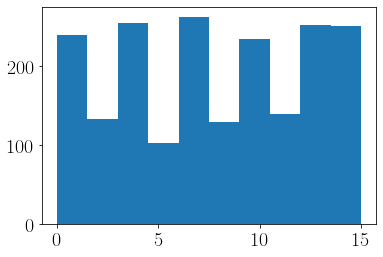

In [19]:
plt.hist(samples.numpy())

In [20]:
paramsg = generator.weights
generated_probabilities = circuit(1,paramsg).detach()

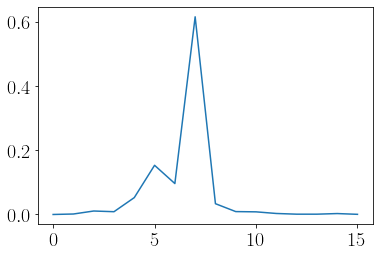

In [21]:
plt.plot(generated_probabilities)